<a href="https://colab.research.google.com/github/hrampadarath/Deep_Learning_examples/blob/main/BearGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BearGAN

An experimental DCGAN to generate new Being Bears images.

The images are from my artwork of the raw being bears images that are used to create the being bears comics. They have been reduced to image size of 256x160,although there are a few with 256x205 pixels. 


Invaluable resource: https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/


In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## load the images from the Google Drive folder


In [ ]:
# add google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import tarfile
#tar = tarfile.open('/content/drive/My Drive/datasets/bears.tgz', 'r')
#tar.extractall('/content/drive/My Drive/datasets/bearImages')

In [ ]:
import glob
base_dir = '/content/drive/My Drive/datasets/bearImages'    

images = glob.glob(base_dir+"/*.jpg")

len(images)

933

Load the image with PIL

(256, 160)
RGB


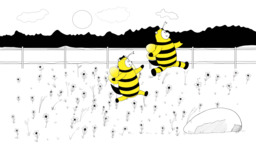

In [ ]:
from PIL import Image
im = Image.open(images[1])
print(im.size)
print(im.mode)
im

This image has color. let's convert to Greyscale and as a numpy array and plot with matplotlib


In [ ]:
im = im.convert("L")
print(im.mode)
import numpy as np
im = np.array(im)
print(im)

L
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


(160, 256)


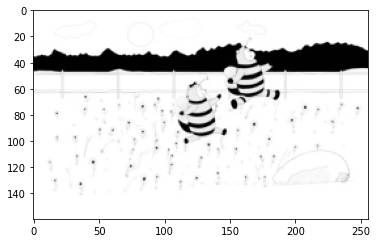

In [ ]:
print(im.shape)
from matplotlib import pyplot
pyplot.imshow(im,cmap='Greys_r')
pyplot.show()

Last thing is to resize the image

(256, 249)
249


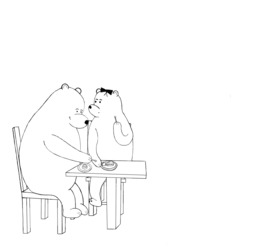

In [ ]:
im = Image.open('/content/drive/My Drive/datasets/bearImages/bears_1421.jpg')
im = im.convert("L")
print(im.size)
print(im.size[1])
im

(256, 160)


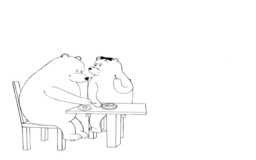

In [ ]:
# resize keeping the aspect ratio
im_r = im.resize((256,160))
print(im_r.size)
im_r

(256, 160)


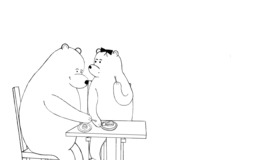

In [ ]:
#crop
im_c = im.crop((0, 40, 256, 200))
print(im_c.size)
im_c

(168, 112)


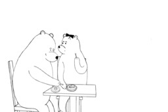

In [ ]:
# resize keeping the aspect ratio
im_r = im_c.resize((168,112))
print(im_r.size)
im_r

Cropping seems better as I don't want to change the shape to bears. The next step is to create a function to convert all images to numpy format.

In [ ]:
from tqdm import tqdm
def bears2Numpy():
  base_dir = '/content/drive/My Drive/datasets/bearImages'    
  images = glob.glob(base_dir+"/*.jpg")
  #images = images[1:10]
  # create empty array
  image_height = 112
  image_width = 168
  ys = np.ndarray(shape=(len(images), image_height, image_width),
                     dtype=np.float32)
  i = 0
  for ims in tqdm(images):
    im = Image.open(ims)

    if im.mode == 'RGB':
      im = im.convert("L")
    if im.size[1] != 160:
      im = im.crop((0, 20, 256, 180))

    im = im.resize((image_width,image_height))

    # convert to numpy array
    im = np.array(im)/255

    #flatten
    #im = im.flatten()
    #ys = np.vstack([ys, np.float32(im)])
    ys[i] = im
    i+=1

  return ys

# Note to self; deleted bear_1393 as it had an incompatible size: 256x 133

In [ ]:
trainBears = bears2Numpy()
trainBears.shape

100%|██████████| 933/933 [00:02<00:00, 426.26it/s]


(933, 112, 168)

In [ ]:
# plot a random sample of bears

def plot_utils(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

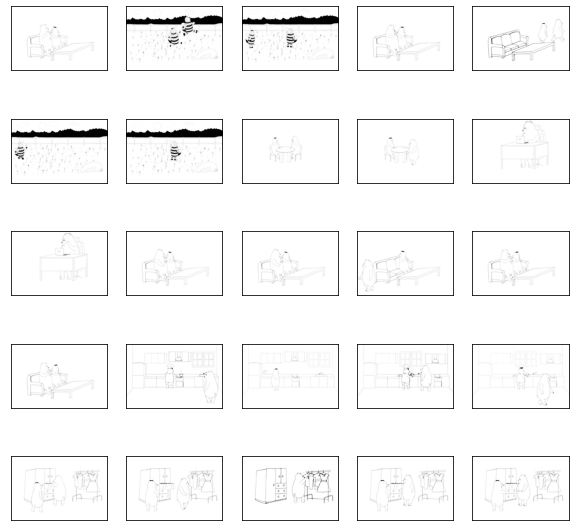

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainBears[i], cmap="Greys_r")
plt.show()

## DCGAN

cuuuute! Ok now to beging the DCGAN part. This bit will be basically copied from [DCGAN.ipynb](https://colab.research.google.com/drive/1ZFAh2zXCVh0Zbezk-GkAu7LVz8qdVqeC?usp=sharing)
At this pont we will switch to gpu.

### Build the Generator Network for DCGAN

In [ ]:
import tensorflow as tf
from tensorflow import keras
num_features = 200
generator = None
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256, (5,5), (4,4), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,3), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

(1, 200)
(1, 112, 168, 1)


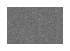

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
print(noise.shape)
generated_images = generator(noise, training=False)
print(generated_images.shape)
plot_utils(generated_images, 1)

### Build the Discriminator Network for DCGAN

This is essentially a CNN

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[112, 168, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49986067]], shape=(1, 1), dtype=float32)


### Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Define Training Procedure

In [ ]:
from IPython import display
def train_dcgan(gan, dataset, batch_size, num_features, seed, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(predictions.shape)
  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='Greys_r')
      plt.axis('off')

  plt.savefig('/content/drive/My Drive/datasets/genBears/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
trainBears_dcgan = trainBears.reshape(-1, 112, 168, 1)
trainBears_dcgan.shape

(933, 112, 168, 1)

In [ ]:
batch_size = 32
seed = tf.random.normal(shape=[batch_size, 200])

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(trainBears_dcgan)
dataset = dataset.shuffle(100)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

(32, 112, 168, 1)


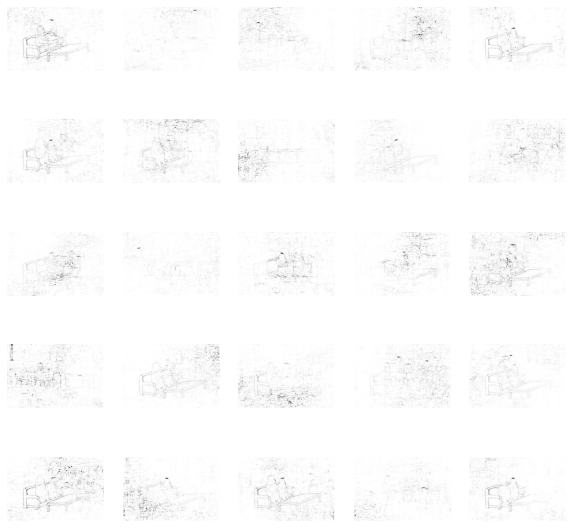

CPU times: user 17min 37s, sys: 3min 35s, total: 21min 13s
Wall time: 56min 38s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, seed, epochs=300)

In [ ]:
import imageio
import glob

anim_file = '/content/drive/My Drive/datasets/genBears/bears_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/My Drive/datasets/genBears/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 5*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#import IPython
#display.Image(filename=anim_file)